# Desafio LATAM

Por Juan PINEDA-JARAMILLO
https://github.com/jdpinedaj


## Problema

El problema consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de
Chile (SCL). Para eso les entregamos un dataset usando datos públicos y reales donde cada fila corresponde a un vuelo que
aterrizó o despegó de SCL.


## Variables

- Fecha-I : Fecha y hora programada del vuelo.
- Vlo-I : Número de vuelo programado.
- Ori-I : Código de ciudad de origen programado.
- Des-I : Código de ciudad de destino programado.
- Emp-I : Código aerolínea de vuelo programado.
- Fecha-O : Fecha y hora de operación del vuelo.
- Vlo-O : Número de vuelo de operación del vuelo.
- Ori-O : Código de ciudad de origen de operación
- Des-O : Código de ciudad de destino de operación.
- Emp-O : Código aerolínea de vuelo operado.
- DIA : Día del mes de operación del vuelo.
- MES : Número de mes de operación del vuelo.
- AÑO : Año de operación del vuelo.
- DIANOM : Día de la semana de operación del vuelo.
- TIPOVUELO : Tipo de vuelo, I =Internacional, N =Nacional.
- OPERA : Nombre de aerolínea que opera.
- SIGLAORI : Nombre ciudad origen.
- SIGLADES : Nombre ciudad destino.


## Importando las librerías


In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
from datetime import datetime as dt
import requests
from pandas_profiling import ProfileReport
from math import *
import imblearn
from pycaret.classification import *
from pycaret.utils import check_metric
import shap

# sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# settings to display all columns
pd.set_option("display.max_columns", None)


In [2]:
# Leyendo los datos y definiendo todas las columnas como tipo string
data = pd.read_csv('../data/input/dataset_SCL.csv', dtype=str)
data.head()


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [3]:
# Poniendo los nombres de las columnas como minúsculas
data.columns = data.columns.str.lower()

# Reemplazando '-' por '_' para facilidad en la manipulación/selección de variables
data.columns = data.columns.str.replace('-', '_')

# Cambiando tipos de datos
data['fecha_i'] = pd.to_datetime(data['fecha_i'])
data['fecha_o'] = pd.to_datetime(data['fecha_o'])

data['dia'] = pd.to_numeric(data['dia'])
data['mes'] = pd.to_numeric(data['mes'])
data['año'] = pd.to_numeric(data['año'])

# Removiendo filas del año 2018 porque solo hay 2 valores
data = data[data['año'] != 2018]


In [4]:
data.head()


,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68204 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fecha_i    68204 non-null  datetime64[ns]
 1   vlo_i      68204 non-null  object        
 2   ori_i      68204 non-null  object        
 3   des_i      68204 non-null  object        
 4   emp_i      68204 non-null  object        
 5   fecha_o    68204 non-null  datetime64[ns]
 6   vlo_o      68203 non-null  object        
 7   ori_o      68204 non-null  object        
 8   des_o      68204 non-null  object        
 9   emp_o      68204 non-null  object        
 10  dia        68204 non-null  int64         
 11  mes        68204 non-null  int64         
 12  año        68204 non-null  int64         
 13  dianom     68204 non-null  object        
 14  tipovuelo  68204 non-null  object        
 15  opera      68204 non-null  object        
 16  siglaori   68204 non-null  object       

### Desafío 1

¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?


In [6]:
data.describe(include='all', datetime_is_numeric=True)


,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades
count,68204,68204,68204,68204,68204,68204,68203,68204,68204,68204,68204.000000,68204.000000,68204.0,68204,68204,68204,68204,68204
unique,NaN,584,1,64,30,NaN,861,1,63,32,NaN,NaN,NaN,7,2,23,1,62
top,NaN,174,SCEL,SCFA,LAN,NaN,174,SCEL,SCFA,LAN,NaN,NaN,NaN,Viernes,N,Grupo LATAM,Santiago,Buenos Aires
freq,NaN,686,68204,5787,37609,NaN,649,68204,5786,20986,NaN,NaN,NaN,10292,36966,40890,68204,6335
mean,2017-07-05 12:03:50.585302784,NaN,NaN,NaN,NaN,2017-07-05 12:12:57.218344960,NaN,NaN,NaN,NaN,15.715222,6.622749,2017.0,NaN,NaN,NaN,NaN,NaN
min,2017-01-01 00:15:00,NaN,NaN,NaN,NaN,2017-01-01 00:04:00,NaN,NaN,NaN,NaN,1.000000,1.000000,2017.0,NaN,NaN,NaN,NaN,NaN
25%,2017-03-31 12:40:00,NaN,NaN,NaN,NaN,2017-03-31 12:48:30,NaN,NaN,NaN,NaN,8.000000,3.000000,2017.0,NaN,NaN,NaN,NaN,NaN
50%,2017-07-10 05:25:00,NaN,NaN,NaN,NaN,2017-07-10 05:34:30,NaN,NaN,NaN,NaN,16.000000,7.000000,2017.0,NaN,NaN,NaN,NaN,NaN
75%,2017-10-08 10:48:45,NaN,NaN,NaN,NaN,2017-10-08 11:05:30,NaN,NaN,NaN,NaN,23.000000,10.000000,2017.0,NaN,NaN,NaN,NaN,NaN
max,2017-12-31 23:55:00,NaN,NaN,NaN,NaN,2017-12-31 23:53:00,NaN,NaN,NaN,NaN,31.000000,12.000000,2017.0,NaN,NaN,NaN,NaN,NaN


A contiunuación se genera un reporte de la base de datos utilizando ProfileReport, y se guarda en formato html:

profile = ProfileReport(data, title='Report')
profile.to_file('../data/output/Report.html')

profile


In [7]:
# Aeropuertos ubicados en la ciudad de Buenos Aires
data[data['siglades'] == 'Buenos Aires']['des_i'].value_counts()


SAEZ    3240
SABE    3094
SEGU       1
Name: des_i, dtype: int64

#### Conclusiones

- Todos los vuelos salian desde Santiago de Chile (tal cual se comentaba en el problema).
- La mayoria de vuelos fueron operados por Grupo LATAM (60%).
- 54.2% de los vuelos son nacionales.
- La mayoria de destinos fueron Antofagasta(Cl) 8.5%, Lima(Pe) 7.7%, El Loa(Cl) 7.5%, El Tepual(Cl) 6.4%, Concepcion(Cl) 5.9%, Iquique(Cl) 5.5%, Sao Paulo(Br) 5.2%, Ezeiza(Arg) 4.8%, donde estos 9 destinos, de 64 en total, representaron mas del 50% de los vuelos. Sin embargo, la principal ciudad de destino fue Buenos Aires(Ar) con 9.29% de los vuelos a sus dos aeropuertos SAEZ y SABE.
- Hay una tendencia de un mayor numero de vuelos en los meses de inicio y fin de año, cuando es verano en el cono sur (viajes de vacaciones?).
- El dia de la semana con mayor numero de operaciones es viernes (15% de los vuelos)


### Desafío 2

Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :

- temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
- dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
- atraso_15 : 1 si dif_min > 15, 0 si no.
- periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a
  Fecha-I .


In [8]:
# Definiendo la función "is_in_range" para devolver 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, o 0 si no.
def is_in_range(date):
    """
    Returns 1 if date is in range, 0 if not
    """

    if (date.month == 12 and date.day >= 15) or (date.month == 1) or (
            date.month == 2) or (date.month == 3 and date.day <= 3):
        return 1
    elif (date.month == 7 and date.day >= 15):
        return 1
    elif (date.month == 9 and date.day >= 11):
        return 1
    else:
        return 0


# Definiendo la función "difference_mins" para calcular la diferencia en minutos entre dos datetimes
def difference_mins(date_after, date_before):
    """
    Returns difference in minutes between two datetimes
    """
    return (date_after - date_before).total_seconds() / 60


# # Definiendo la función "period_day" para identificar si el periodo delñ día es mañana, tarde o noche, considerando la variable fecha_i
def period_day(date):
    """
    Returns morning, afternoon or night according to date
    """
    if date.hour >= 5 and date.hour < 12:
        return 'mañana'
    elif date.hour >= 12 and date.hour < 19:
        return 'tarde'
    else:
        return 'noche'


In [9]:
# Creando el DataFrame "synthetic_features" como un DataFrame vacío
synthetic_features = pd.DataFrame()

# Se aplican las funciones previamente creadas
synthetic_features['temporada_alta'] = data['fecha_i'].apply(is_in_range)
synthetic_features['dif_min'] = data.apply(
    lambda x: difference_mins(x['fecha_o'], x['fecha_i']), axis=1)
synthetic_features['atraso_15'] = synthetic_features['dif_min'].apply(
    lambda x: 1 if x > 15 else 0)
synthetic_features['periodo_dia'] = data['fecha_i'].apply(period_day)
synthetic_features.head()

# Se exporta el DataFrame a csv y se guarda en el repo
synthetic_features.to_csv('../data/output/synthetic_features.csv', index=False)


In [10]:
synthetic_features.describe(datetime_is_numeric=True)


,temporada_alta,dif_min,atraso_15
count,68204.000000,68204.000000,68204.000000
mean,0.333705,9.110551,0.184931
std,0.471539,19.313470,0.388244
min,0.000000,-14.000000,0.000000
25%,0.000000,-1.000000,0.000000
50%,0.000000,4.000000,0.000000
75%,1.000000,12.000000,0.000000
max,1.000000,161.000000,1.000000


### Desafío 3

- ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
- ¿Qué variables esperarías que más influyeran en predecir atrasos?


In [11]:
# Combinando datos
data_merged = pd.merge(data,
                       synthetic_features,
                       left_index=True,
                       right_index=True)

# Calculando número de filas antes de eliminar outliers
rows_with_outliers = data_merged.shape[0]

# Removiendo outliers en la variable "dif_min" utilizando el Rango intercuartílico (IQR)
data_merged = data_merged[
    data_merged['dif_min'] < data_merged['dif_min'].quantile(0.75) + 1.5 *
    (data_merged['dif_min'].quantile(0.75) -
     data_merged['dif_min'].quantile(0.25))]

# Calculando número de filas después de eliminar outliers
rows_without_outliers = data_merged.shape[0]

# Calculando número de filas removidas
print('Rows removed:', rows_with_outliers - rows_without_outliers)
print('-----------------------------------------------------')

data_merged.head()


Rows removed: 5197
-----------------------------------------------------


,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades,temporada_alta,dif_min,atraso_15,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,noche
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0,noche
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0,noche
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0,0,noche
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0,0,noche


In [12]:
# Seleccionando el top 10 destinos con mayor número de vuelos
top_10_siglades = data_merged['siglades'].value_counts().head(
    10).index.tolist()

# Seleccionando el top 10 operadores con mayor número de vuelos
top_10_opera = data_merged['opera'].value_counts().head(10).index.tolist()


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


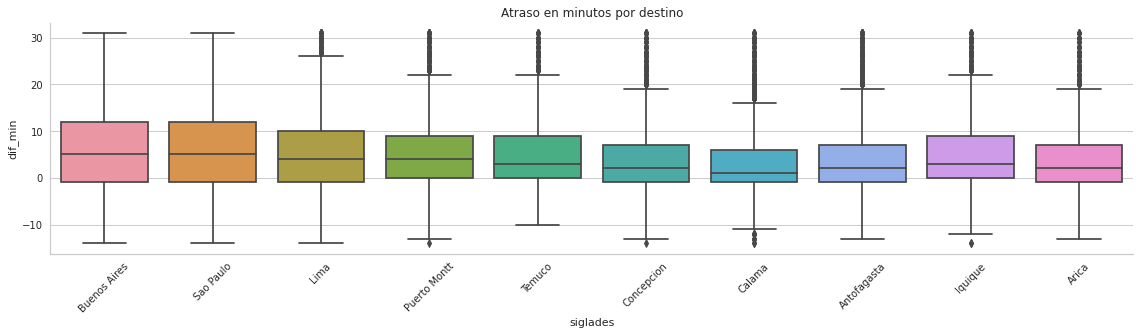

In [13]:
# Tasa de atraso por destino, en minutos

sns.catplot(x="siglades",
            y="dif_min",
            kind="box",
            data=data_merged[data_merged['siglades'].isin(top_10_siglades)],
            height=4,
            aspect=4 / 1)
plt.xticks(rotation=45)
plt.title('Atraso en minutos por destino')
plt.show()


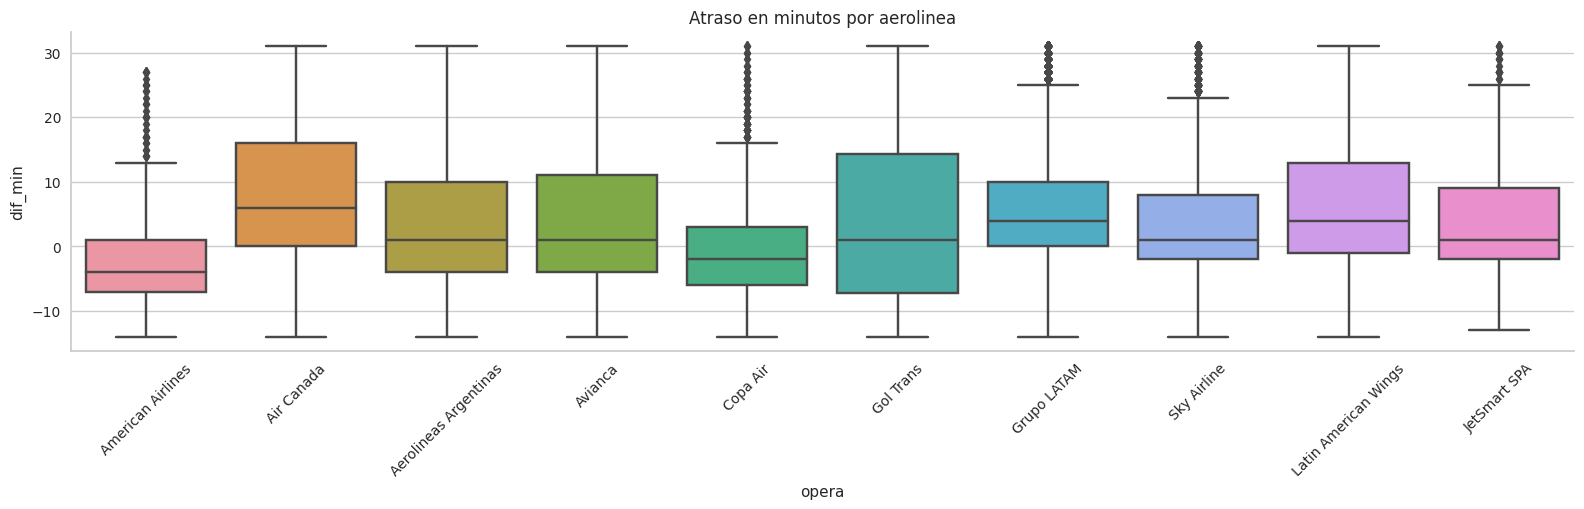

In [14]:
# Tasa de atraso por aerolinea, en minutos

sns.catplot(x="opera",
            y="dif_min",
            kind="box",
            data=data_merged[data_merged['opera'].isin(top_10_opera)],
            height=4,
            aspect=4 / 1)
plt.xticks(rotation=45)
plt.title('Atraso en minutos por aerolinea')
plt.show()


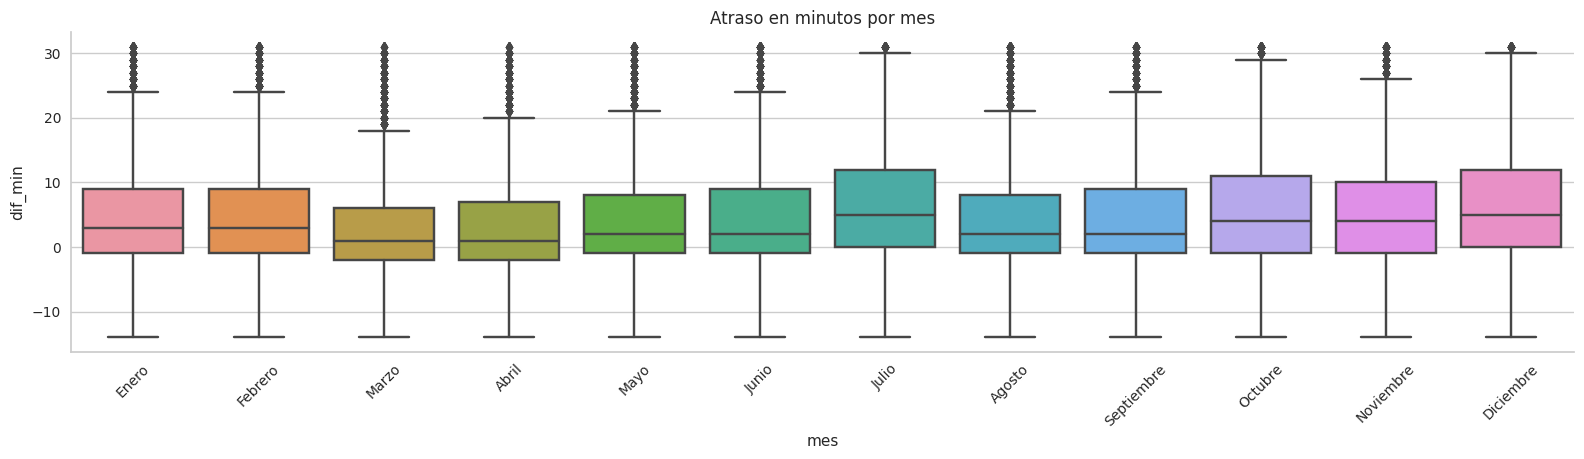

In [15]:
# Tasa de atraso por mes, en minutos

g = sns.catplot(x="mes",
                y="dif_min",
                kind="box",
                data=data_merged,
                height=4,
                aspect=4 / 1)
plt.xticks(rotation=45)
g.set_xticklabels([
    'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto',
    'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'
])
plt.title('Atraso en minutos por mes')
plt.show()


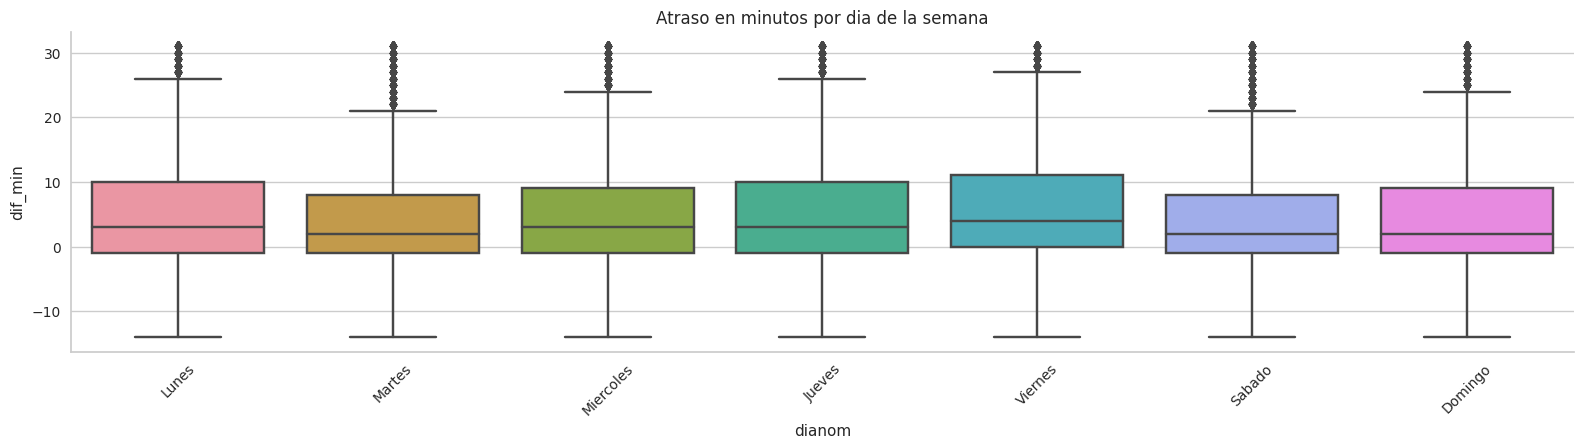

In [16]:
# Tasa de atraso por día de la semana, en minutos
order = [
    'Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo'
]

sns.catplot(x="dianom",
            y="dif_min",
            kind="box",
            data=data_merged,
            height=4,
            aspect=4 / 1,
            order=order)
plt.xticks(rotation=45)
plt.title('Atraso en minutos por dia de la semana')
plt.show()


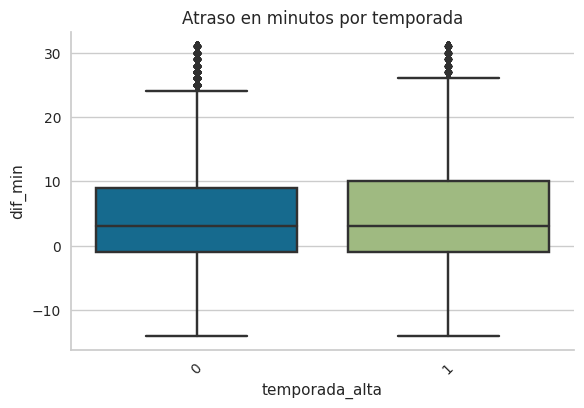

In [17]:
# Tasa de atraso por temporada, en minutos

sns.catplot(x="temporada_alta",
            y="dif_min",
            kind="box",
            data=data_merged,
            height=4,
            aspect=3 / 2)
plt.xticks(rotation=45)
plt.title('Atraso en minutos por temporada')
plt.show()


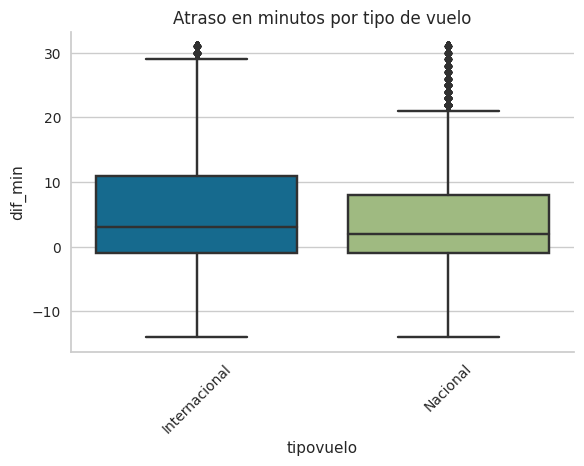

In [18]:
# Tasa de atraso por tipo de vuelo, en minutos

g = sns.catplot(x="tipovuelo",
                y="dif_min",
                kind="box",
                data=data_merged,
                height=4,
                aspect=3 / 2)
plt.xticks(rotation=45)
g.set_xticklabels(['Internacional', 'Nacional'])
plt.title('Atraso en minutos por tipo de vuelo')
plt.show()


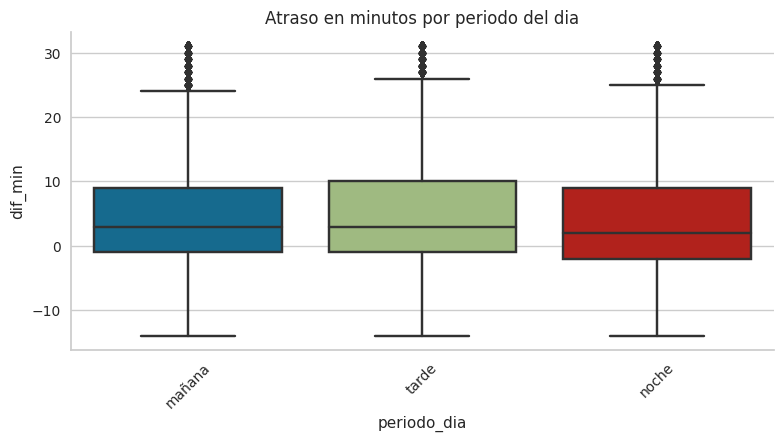

In [19]:
#  Tasa de atraso por periodo del día, en minutos
order = ['mañana', 'tarde', 'noche']
sns.catplot(x="periodo_dia",
            y="dif_min",
            kind="box",
            data=data_merged,
            height=4,
            aspect=2 / 1,
            order=order)
plt.xticks(rotation=45)
plt.title('Atraso en minutos por periodo del dia')
plt.show()


In [20]:
# Atrasos debido al día de la semana y del mes?

week = data_merged[['dianom', 'atraso_15'
                    ]].groupby('dianom').sum().sort_values(by='atraso_15',
                                                           ascending=False)
week['percentual'] = week['atraso_15'] / (week['atraso_15'].sum()) * 100
month = data_merged[['dia', 'atraso_15'
                     ]].groupby('dia').sum().sort_values(by='atraso_15',
                                                         ascending=False)
month['percentual'] = month['atraso_15'] / (month['atraso_15'].sum()) * 100

print('Delayed flights by weekday: ')
print(week)
print('--------------')
print('Delayed flights by monthday: ')
print(month)


Delayed flights by weekday: 
           atraso_15  percentual
dianom                          
Viernes         1348   18.176915
Jueves          1221   16.464401
Lunes           1161   15.655340
Miercoles        969   13.066343
Martes           962   12.971953
Domingo          946   12.756203
Sabado           809   10.908846
--------------
Delayed flights by monthday: 
     atraso_15  percentual
dia                       
26         287    3.870011
10         285    3.843042
15         281    3.789105
11         273    3.681230
16         273    3.681230
12         264    3.559871
22         260    3.505933
14         259    3.492449
20         257    3.465480
17         256    3.451996
13         255    3.438511
6          251    3.384574
19         247    3.330636
3          246    3.317152
21         245    3.303668
18         242    3.263215
24         242    3.263215
4          241    3.249730
23         241    3.249730
9          237    3.195793
5          234    3.155340
27      

Jueves y viernes hay mayor porcentaje de vuelos atrasados, mientras que sábados y domingos son días con menor porcentaje de vuelos atrasados.

In [21]:
# Qué destino es el que tiene mayor porcentaje de vuelos atrasados?
dest_later = data_merged[['siglades',
                          'atraso_15']].groupby('siglades').sum().sort_values(
                              by='atraso_15', ascending=False)
dest_later['percentual'] = dest_later['atraso_15'] / (
    dest_later['atraso_15'].sum()) * 100
dest_later.head()


,atraso_15,percentual
siglades,,
Buenos Aires,964,12.998921
Lima,675,9.101942
Antofagasta,524,7.065804
Sao Paulo,500,6.742179
Puerto Montt,454,6.121899


Buenos Aires y Lima son los destinos con mayor porcentaje de vuelos atrasados.

In [22]:
# Creando una nueva columna que cuenta el número de vuelos atrasados por destino
count_later_dest = data_merged[[
    'siglades', 'atraso_15'
]].groupby('siglades').sum().sort_values(by='atraso_15', ascending=False)
count_later_dest.reset_index(inplace=True)
data_merged_2 = data_merged.merge(count_later_dest,
                                  left_on='siglades',
                                  right_on='siglades')
data_merged_2.rename(
    {
        'atraso_15_y': 'count_later_destino',
        'atraso_15_x': 'atraso_15'
    },
    inplace=True,
    axis=1)

# Creando una nueva columna que cuenta el número de vuelos atrasados por operador
count_later_emp = data_merged_2[[
    'opera', 'atraso_15'
]].groupby('opera').sum().sort_values(by='atraso_15', ascending=False)
count_later_emp.reset_index(inplace=True)
data_merged_3 = data_merged_2.merge(count_later_emp,
                                    left_on='opera',
                                    right_on='opera')
data_merged_3.rename(
    {
        'atraso_15_y': 'count_later_empresa',
        'atraso_15_x': 'atraso_15'
    },
    inplace=True,
    axis=1)

# Creando una nueva columna que cuenta el número de vuelos atrasados por periodo del día
count_later_periodo = data_merged_3[[
    'periodo_dia', 'atraso_15'
]].groupby('periodo_dia').sum().sort_values(by='atraso_15', ascending=False)
count_later_periodo.reset_index(inplace=True)
data_merged_4 = data_merged_3.merge(count_later_periodo,
                                    left_on='periodo_dia',
                                    right_on='periodo_dia')
data_merged_4.rename(
    {
        'atraso_15_y': 'count_later_periodo',
        'atraso_15_x': 'atraso_15'
    },
    inplace=True,
    axis=1)

# Creando una nueva columna que cuenta el número de vuelos atrasados por periodo del día-mes-día (atrasos en el mismo día, por periodo)
data_merged_4['periodo_dia_mes_dia'] = data_merged_4['periodo_dia'].astype(
    str) + '-' + data_merged_4['mes'].astype(
        str) + '-' + data_merged_4['dia'].astype(str)
count_later_periodo_dia_mes_dia = data_merged_4[[
    'periodo_dia_mes_dia', 'atraso_15'
]].groupby('periodo_dia_mes_dia').sum().sort_values(by='atraso_15',
                                                    ascending=False)
count_later_periodo_dia_mes_dia.reset_index(inplace=True)
data_merged_5 = data_merged_4.merge(count_later_periodo_dia_mes_dia,
                                    left_on='periodo_dia_mes_dia',
                                    right_on='periodo_dia_mes_dia')
data_merged_5.rename(
    {
        'atraso_15_y': 'count_later_periodo_dia_mes_dia',
        'atraso_15_x': 'atraso_15'
    },
    inplace=True,
    axis=1)

# Saving data to csv
data_merged_5.to_csv('../data/output/data_merged.csv', index=False)

data_merged_5.head()


,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades,temporada_alta,dif_min,atraso_15,periodo_dia,count_later_destino,count_later_empresa,count_later_periodo,periodo_dia_mes_dia,count_later_periodo_dia_mes_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,noche,107,25,1850,noche-1-1,4
1,2017-01-01 22:00:00,912,SCEL,KMIA,AAL,2017-01-01 22:15:00,912,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,15.0,0,noche,107,25,1850,noche-1-1,4
2,2017-01-01 22:30:00,940,SCEL,KDFW,AAL,2017-01-01 22:31:00,940,SCEL,KDFW,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Dallas,1,1.0,0,noche,16,25,1850,noche-1-1,4
3,2017-01-01 23:35:00,500,SCEL,KMIA,LAN,2017-01-01 23:42:00,500,SCEL,KMIA,LAN,1,1,2017,Domingo,I,Grupo LATAM,Santiago,Miami,1,7.0,0,noche,107,4580,1850,noche-1-1,4
4,2017-01-01 22:45:00,502,SCEL,KMIA,LAN,2017-01-01 23:02:00,502,SCEL,KMIA,LAN,1,1,2017,Domingo,I,Grupo LATAM,Santiago,Miami,1,17.0,1,noche,107,4580,1850,noche-1-1,4


#### Conclusiones

De las variables analizadas, las que mas podrian influir en la predicción de atrasos son la aerolínea que opera el vuelo y el mes del año.


### Desafio 4

Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo.\
Siéntete libre de generar variables adicionales y/o complementar con variables externas.


#### Generando variables adicionales


In [23]:
# Leyendo los datos del csv de nuevo para evitar correr nuevamente todo el notebook hacia atrás (checkpoint)
data_merged_5 = pd.read_csv('../data/output/data_merged.csv')

# Cargando datos de aeropuertos obtenida del siguiente link de Kaggle: https://www.kaggle.com/datasets/jinbonnie/airport-information?resource=download
airport_additional_info = pd.read_csv('../data/input/airport_code.csv',
                                      keep_default_na=False,
                                      na_values=[''])


In [24]:
# Se crea el dataframe "data_final" como una copia de "data_merged_5"
data_final = data_merged_5.copy()

# Combinando los datos de las dos fuentes antes cargadas (data_final con airport_additional_info) para enriquecer nuestros datos iniciales con la siguiente información de la tabla adicional: type, latitude, longitude, elevation_ft (to m).
# Se usa la variable gps_code como la llave para unir con la variable "des_i" de nuestra tabla original.
data_final = pd.merge(data_final,
                      airport_additional_info[[
                          'gps_code', 'type', 'latitude_deg', 'longitude_deg',
                          'elevation_ft', 'continent', 'iso_country'
                      ]],
                      left_on='des_i',
                      right_on='gps_code',
                      how='left').drop(columns=['gps_code'])

# Se renombran las columnas nuevas al español, y con el sufijo "_destino"
data_final.rename(columns={
    'type': 'tipo_aeropuerto_destino',
    'latitude_deg': 'lat_destino',
    'longitude_deg': 'lon_destino',
    'elevation_ft': 'elevacion_destino',
    'continent': 'continente_destino',
    'iso_country': 'pais_destino'
},
    inplace=True)

# Se transforma la variable elevación de feets a metros
data_final['elevacion_destino'] = data_final['elevacion_destino'] / 3.28084

# Se agrega la longitud, latitud y elevacion del aeropuerto de Santiago de Chile
data_final['lat_santiago'] = airport_additional_info['latitude_deg'][
    airport_additional_info['ident'] == 'SCEL'].values[0]
data_final['lon_santiago'] = airport_additional_info['longitude_deg'][
    airport_additional_info['ident'] == 'SCEL'].values[0]
data_final['elevacion_santiago'] = airport_additional_info['elevation_ft'][
    airport_additional_info['ident'] == 'SCEL'].values[0] / 3.28084


# Se agregan variables para analizar si el vuelo, la empresa y el destino finales variaron con respecto a su original
data_final['dif_vlo'] = np.where(data_final['vlo_i'] != data_final['vlo_o'], 1,
                                 0)
data_final['dif_emp'] = np.where(data_final['emp_i'] != data_final['emp_o'], 1,
                                 0)
data_final['dif_des'] = np.where(data_final['des_i'] != data_final['des_o'], 1,
                                 0)


# Se crea una función para calcular la distancia entre dos puntos geográficos utilizando la fórmula Haversine
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km


# Se calcula la distancia entre el aeropuerto de Santiago de Chile y los múltiples destinos, utilizando la función previamente creada
data_final['distancia'] = data_final.apply(
    lambda row: haversine(row['lat_santiago'], row['lon_santiago'], row[
        'lat_destino'], row['lon_destino']),
    axis=1)


In [25]:
data_final.describe(include='all')


,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades,temporada_alta,dif_min,atraso_15,periodo_dia,count_later_destino,count_later_empresa,count_later_periodo,periodo_dia_mes_dia,count_later_periodo_dia_mes_dia,tipo_aeropuerto_destino,lat_destino,lon_destino,elevacion_destino,continente_destino,pais_destino,lat_santiago,lon_santiago,elevacion_santiago,dif_vlo,dif_emp,dif_des,distancia
count,63007,63007,63007,63007,63007,63007,63006,63007,63007,63007,63007.000000,63007.000000,63007.0,63007,63007,63007,63007,63007,63007.000000,63007.000000,63007.000000,63007,63007.000000,63007.000000,63007.000000,63007,63007.000000,63007,63007.000000,63007.000000,63007.000000,63007,63007,6.300700e+04,6.300700e+04,6.300700e+04,63007.000000,63007.000000,63007.000000,63007.000000
unique,50025,832,1,61,30,58334,824,1,61,31,NaN,NaN,NaN,7,2,23,1,60,NaN,NaN,NaN,3,NaN,NaN,NaN,1095,NaN,3,NaN,NaN,NaN,4,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2017-03-26 18:00:00,11,SCEL,SCFA,LAN,2017-05-19 07:01:00,11,SCEL,SCFA,LAN,NaN,NaN,NaN,Jueves,N,Grupo LATAM,Santiago,Buenos Aires,NaN,NaN,NaN,mañana,NaN,NaN,NaN,tarde-11-12,NaN,medium_airport,NaN,NaN,NaN,SA,CL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,6,586,63007,5464,35241,5,634,63007,5463,19568,NaN,NaN,NaN,9427,34772,38165,63007,5679,NaN,NaN,NaN,23828,NaN,NaN,NaN,83,NaN,40684,NaN,NaN,NaN,55659,34772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.727697,6.562017,2017.0,NaN,NaN,NaN,NaN,NaN,0.332439,4.707858,0.117701,NaN,375.326710,3106.285079,2548.630565,NaN,7.115939,NaN,-21.919809,-66.157752,399.942412,NaN,NaN,-3.339300e+01,-7.078580e+01,4.739640e+02,0.496294,0.273557,0.000349,2157.552005
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.817121,3.530607,0.0,NaN,NaN,NaN,NaN,NaN,0.471091,8.414519,0.322257,NaN,258.548683,1875.956409,457.033585,NaN,4.559688,NaN,20.814627,24.769017,748.068418,NaN,NaN,7.105484e-15,1.421097e-14,5.684387e-14,0.499990,0.445788,0.018683,2331.734730
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,2017.0,NaN,NaN,NaN,NaN,NaN,0.000000,-14.000000,0.000000,NaN,0.000000,5.000000,1850.000000,NaN,0.000000,NaN,-54.843300,-118.407997,2.438400,NaN,NaN,-3.339300e+01,-7.078580e+01,4.739640e+02,0.000000,0.000000,0.000000,195.820849
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,3.000000,2017.0,NaN,NaN,NaN,NaN,NaN,0.000000,-1.000000,0.000000,NaN,206.000000,1477.000000,2534.000000,NaN,4.000000,NaN,-34.822200,-73.094002,34.442399,NaN,NaN,-3.339300e+01,-7.078580e+01,4.739640e+02,0.000000,0.000000,0.000000,917.489520
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,7.000000,2017.0,NaN,NaN,NaN,NaN,NaN,0.000000,3.000000,0.000000,NaN,377.000000,4580.000000,2534.000000,NaN,6.000000,NaN,-23.444501,-70.445099,89.611197,NaN,NaN,-3.339300e+01,-7.078580e+01,4.739640e+02,0.000000,0.000000,0.000000,1225.395827
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,10.000000,2017.0,NaN,NaN,NaN,NaN,NaN,1.000000,9.000000,0.000000,NaN,524.000000,4580.000000,3032.000000,NaN,10.000000,NaN,-18.348499,-68.792900,204.215993,NaN,NaN,-3.339300e+01,-7.078580e+01,4.739640e+02,1.000000,1.000000,0.000000,2461.893077


In [26]:
data_final.head()


,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades,temporada_alta,dif_min,atraso_15,periodo_dia,count_later_destino,count_later_empresa,count_later_periodo,periodo_dia_mes_dia,count_later_periodo_dia_mes_dia,tipo_aeropuerto_destino,lat_destino,lon_destino,elevacion_destino,continente_destino,pais_destino,lat_santiago,lon_santiago,elevacion_santiago,dif_vlo,dif_emp,dif_des,distancia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,noche,107,25,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NA,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095
1,2017-01-01 22:00:00,912,SCEL,KMIA,AAL,2017-01-01 22:15:00,912,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,15.0,0,noche,107,25,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NA,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095
2,2017-01-01 22:30:00,940,SCEL,KDFW,AAL,2017-01-01 22:31:00,940,SCEL,KDFW,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Dallas,1,1.0,0,noche,16,25,1850,noche-1-1,4,large_airport,32.896801,-97.038002,185.013594,NA,US,-33.393002,-70.785797,473.963985,0,0,0,7866.284042
3,2017-01-01 23:35:00,500,SCEL,KMIA,LAN,2017-01-01 23:42:00,500,SCEL,KMIA,LAN,1,1,2017,Domingo,I,Grupo LATAM,Santiago,Miami,1,7.0,0,noche,107,4580,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NA,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095
4,2017-01-01 22:45:00,502,SCEL,KMIA,LAN,2017-01-01 23:02:00,502,SCEL,KMIA,LAN,1,1,2017,Domingo,I,Grupo LATAM,Santiago,Miami,1,17.0,1,noche,107,4580,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NA,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095


In [27]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

# Set time period
start = datetime(2018, 1, 1)
end = datetime(2018, 1, 1)

# Create Point for Vancouver, BC
location = Point(49.2497, -123.1193, 70)

# Get daily data for 2018
data = Daily(location, start, end)
# fetching tavg and
data = data.fetch()['tavg'].values.tolist()
data


[1.8]

In [28]:
# Obteniendo datos climaticos para origen y destino usando meteostat
from meteostat import Point, Hourly, Daily


def get_weather_data(lat, lon, elev, start, end):
    """
    Función para obtener datos climáticos de la API de Meteostat
    Args:
        lat (float): Latitud del punto
        lon (float): Longitud del punto
        start (str): Fecha de inicio en formato YYYY-MM-DD
        end (str): Fecha de término en formato YYYY-MM-DD
    Returns:
        DataFrame: DataFrame con los datos climáticos
    """

    # Defining starts and end
    start = dt.strptime(start, '%Y-%m-%d %H:%M:%S')
    start = start.strftime('%Y-%m-%d')
    start = dt.strptime(start, '%Y-%m-%d')
    end = dt.strptime(end, '%Y-%m-%d %H:%M:%S')
    end = end.strftime('%Y-%m-%d')
    end = dt.strptime(end, '%Y-%m-%d')

    # Create point for location
    point = Point(lat, lon, elev)
    # Get daily data for 2018
    data = Daily(point, start, end)
    # Extracting the features
    tavg = data.fetch()['tavg'].values.tolist()
    tmin = data.fetch()['tmin'].values.tolist()
    tmax = data.fetch()['tmax'].values.tolist()
    prcp = data.fetch()['prcp'].values.tolist()
    snow = data.fetch()['snow'].values.tolist()
    wdir = data.fetch()['wdir'].values.tolist()
    wspd = data.fetch()['wspd'].values.tolist()
    wpgt = data.fetch()['wpgt'].values.tolist()
    pres = data.fetch()['pres'].values.tolist()
    tsun = data.fetch()['tsun'].values.tolist()

    return tavg, tmin, tmax, prcp, snow, wdir, wspd, wpgt, pres, tsun


# Obteniendo datos climaticos para destino usando meteostat para todo el dataframe data_final
data_prueba = data_final.head(10).copy()
data_prueba.head()

,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades,temporada_alta,dif_min,atraso_15,periodo_dia,count_later_destino,count_later_empresa,count_later_periodo,periodo_dia_mes_dia,count_later_periodo_dia_mes_dia,tipo_aeropuerto_destino,lat_destino,lon_destino,elevacion_destino,continente_destino,pais_destino,lat_santiago,lon_santiago,elevacion_santiago,dif_vlo,dif_emp,dif_des,distancia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,noche,107,25,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NA,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095
1,2017-01-01 22:00:00,912,SCEL,KMIA,AAL,2017-01-01 22:15:00,912,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,15.0,0,noche,107,25,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NA,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095
2,2017-01-01 22:30:00,940,SCEL,KDFW,AAL,2017-01-01 22:31:00,940,SCEL,KDFW,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Dallas,1,1.0,0,noche,16,25,1850,noche-1-1,4,large_airport,32.896801,-97.038002,185.013594,NA,US,-33.393002,-70.785797,473.963985,0,0,0,7866.284042
3,2017-01-01 23:35:00,500,SCEL,KMIA,LAN,2017-01-01 23:42:00,500,SCEL,KMIA,LAN,1,1,2017,Domingo,I,Grupo LATAM,Santiago,Miami,1,7.0,0,noche,107,4580,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NA,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095
4,2017-01-01 22:45:00,502,SCEL,KMIA,LAN,2017-01-01 23:02:00,502,SCEL,KMIA,LAN,1,1,2017,Domingo,I,Grupo LATAM,Santiago,Miami,1,17.0,1,noche,107,4580,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NA,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095


In [29]:
data_final.head()

,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades,temporada_alta,dif_min,atraso_15,periodo_dia,count_later_destino,count_later_empresa,count_later_periodo,periodo_dia_mes_dia,count_later_periodo_dia_mes_dia,tipo_aeropuerto_destino,lat_destino,lon_destino,elevacion_destino,continente_destino,pais_destino,lat_santiago,lon_santiago,elevacion_santiago,dif_vlo,dif_emp,dif_des,distancia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,noche,107,25,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NA,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095
1,2017-01-01 22:00:00,912,SCEL,KMIA,AAL,2017-01-01 22:15:00,912,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,15.0,0,noche,107,25,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NA,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095
2,2017-01-01 22:30:00,940,SCEL,KDFW,AAL,2017-01-01 22:31:00,940,SCEL,KDFW,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Dallas,1,1.0,0,noche,16,25,1850,noche-1-1,4,large_airport,32.896801,-97.038002,185.013594,NA,US,-33.393002,-70.785797,473.963985,0,0,0,7866.284042
3,2017-01-01 23:35:00,500,SCEL,KMIA,LAN,2017-01-01 23:42:00,500,SCEL,KMIA,LAN,1,1,2017,Domingo,I,Grupo LATAM,Santiago,Miami,1,7.0,0,noche,107,4580,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NA,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095
4,2017-01-01 22:45:00,502,SCEL,KMIA,LAN,2017-01-01 23:02:00,502,SCEL,KMIA,LAN,1,1,2017,Domingo,I,Grupo LATAM,Santiago,Miami,1,17.0,1,noche,107,4580,1850,noche-1-1,4,large_airport,25.793200,-80.290604,2.438400,NA,US,-33.393002,-70.785797,473.963985,0,0,0,6657.490095


In [ ]:
# data_prueba = data_final.head(12).copy()

# Aplicando funcion get_weather_data for each row

data_final['tavg_dest'], data_final['tmin_dest'], data_final['tmax_dest'], data_final['prcp_dest'], data_final['snow_dest'], data_final['wdir_dest'], data_final['wspd_dest'], data_final['wpgt_dest'], data_final['pres_dest'], data_final['tsun_dest'] = zip(*data_final.apply(lambda x: get_weather_data(x['lat_destino'], x['lon_destino'], x['elevacion_destino'], x['fecha_o'], x['fecha_o']), axis=1))
data_final['tavg_santiago'], data_final['tmin_santiago'], data_final['tmax_santiago'], data_final['prcp_santiago'], data_final['snow_santiago'], data_final['wdir_santiago'], data_final['wspd_santiago'], data_final['wpgt_santiago'], data_final['pres_santiago'], data_final['tsun_santiago'] = zip(*data_final.apply(lambda x: get_weather_data(x['lat_santiago'], x['lon_santiago'], x['elevacion_santiago'], x['fecha_o'], x['fecha_o']), axis=1))

for i in ['tavg_dest', 'tmin_dest', 'tmax_dest', 'prcp_dest', 'snow_dest', 'wdir_dest', 'wspd_dest', 'wpgt_dest', 'pres_dest', 'tsun_dest', 'tavg_santiago', 'tmin_santiago', 'tmax_santiago', 'prcp_santiago', 'snow_santiago', 'wdir_santiago', 'wspd_santiago', 'wpgt_santiago', 'pres_santiago', 'tsun_santiago']:
    data_final[i] = data_final[i].str[0]

# Guardando el dataset con las variables climáticas
data_final.to_csv('../data/output/data_final.csv', index=False)

data_final.head()
